## To Do

- figure out which image info to extract and fill in (may need to create AP)
- create resources with various files and metadata 
- create queries for these
- add cat to project
- set project public so everyone can create a codespaces from it

# With metadata to better data! (Meta)Data transfer from and to Coscine

The [Coscine research data platform](https://www.coscine.de) provides an API interface to transfer metadata annotated data to Coscine in automated processes. In the workshop, we will show in small-scale steps how to move data to Coscine using a JupyterNotebook (Python) and Coscine's personal authentication token, and how to specify the metadata using the application profile provided by the application. Prior knowledge of Python is desirable.

First things first, you need a Coscine project. You can use your own if you have access, or we will add you to this one: https://coscine.rwth-aachen.de/p/fdmwerkstatt/ 

Next, head to your [user profile](https://coscine.rwth-aachen.de/user/) and get your Access Token. Copy this into your config file under `token`.


Create a resource... 

Go to the resource setting and copy all relevant information into your config file. This includes resource name and ID and project name. 

Now let's load all dependencies and configurations into our jupyter notebook.

We'll need the Coscine module, so let's install:

In [1]:
pip install coscine

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.0/50.0 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 528.1/528.1 kB 17.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.1/77.1 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 kB 1.4 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.1.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [1]:
import coscine
import json
from datetime import datetime
from pathlib import Path
import re 

/home/codespace/.python/current/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Load the configuration:

In [2]:
with open("config.json") as f:
    cfg = json.load(f)

RESOURCE: str = cfg['resourceName']
PROJECT: str = cfg['projectName']
TOKEN: str = cfg['token']

We use the Coscine package to connect with Coscine REST API, which enables us to interact with our project and resource. 

For more information and other examples: [Coscine Python SDK](https://git.rwth-aachen.de/coscine/community-features/coscine-python-sdk)

In [3]:
client = coscine.Client(TOKEN)

project = client.project(PROJECT)
resource = project.resource(RESOURCE)


In [4]:
print(project)

+------------------------------------------------------------------------------+
|                            Project FDM_Werkstatt                             |
+-------------------------+----------------------------------------------------+
|         Property        |                       Value                        |
+-------------------------+----------------------------------------------------+
|            ID           |        ae6aa507-27fb-4e1f-84ab-16f1f4c6d320        |
|           Name          |                   FDM_Werkstatt                    |
|       Display Name      |                   FDM_Werkstatt                    |
|       Description       | With metadata to better data! (Meta)Data transfer  |
|                         |                from and to Coscine                 |
|                         |                                                    |
|                         | The Coscine research data platform provides an API |
|                         | 

In [5]:
print(resource)

+---------------------------------------------------------------------+
|                          Resource Prep_Test                         |
+---------------------+-----------------------------------------------+
|       Property      |                     Value                     |
+---------------------+-----------------------------------------------+
|          ID         |      dc774194-5bb8-4cf0-b84e-93027adec0ea     |
|    Resource Name    |                   Prep_Test                   |
|     Display Name    |                   Prep_Test                   |
|     Description     |               prep fdm_werkstatt              |
|         PID         | 21.11102/dc774194-5bb8-4cf0-b84e-93027adec0ea |
|         Type        |                   rdss3rwth                   |
|     Disciplines     |              Computer Science 409             |
|       License       |                                               |
| Application Profile |       https://purl.org/coscine/ap/base/ 

Get the metadata form and take a look at it:

In [7]:
metadata = resource.metadata_form()
print(metadata)

+---+----------+----------------+-------+
| C | Type     | Property       | Value |
+---+----------+----------------+-------+
|   | [str]    | Title*         |       |
|   | [str]    | Creator*       |       |
|   | datetime | Creation Date* |       |
| V | [str]    | Subject Area   |       |
| V | [str]    | Type           |       |
+---+----------+----------------+-------+


This form is a dictionary-like data structure, so you can interact with it like a python dictionary:

In [8]:
metadata['Title'] = 'My fun title'

In [9]:
metadata['Type'] = 'this thing'

ValueError: Invalid value 'this thing' for vocabulary controlled key 'Type'! Perhaps you meant ?

The error is because the field is a controlled vocabulary. Let's see what is allowed by looking at the controlled vocabulary for that field:

In [10]:
metadata.vocabulary('Type').keys()

['Moving Image',
 'Sound',
 'Collection',
 'Dataset',
 'Event',
 'Image',
 'Interactive Resource',
 'Service',
 'Software',
 'Text',
 'Physical Object',
 'Still Image']

It would be nice if we could just select one instead of typing it out. Let's start by saving the options it to a list:

In [11]:
allowed_vals = metadata.vocabulary('Type').keys()



Lez's take a look at our options:

In [12]:
for i, val in enumerate(allowed_vals):
    print(f'{i}: {val}')

0: Moving Image
1: Sound
2: Collection
3: Dataset
4: Event
5: Image
6: Interactive Resource
7: Service
8: Software
9: Text
10: Physical Object
11: Still Image


Now we can select an index and assign metadata:

In [13]:
metadata['Type'] = allowed_vals[9]

See if it worked:

In [14]:
print(metadata['Type'])


Text


Another option would be to get some user input on which value to use. Let's fill in `Subject Area` like that. Aagin, let's create a list of the allowed values:

In [15]:
allowed_vals = metadata.vocabulary('Subject Area').keys()

First, we initialize an empty dictionary. Then we assign the index of the list as a keys, options as values:

In [16]:
controlled_vocab = {}
for i, val in enumerate(allowed_vals):
    controlled_vocab[i] = val

controlled_vocab

{0: 'Humanities and Social Sciences',
 1: 'Ancient Cultures',
 2: 'Prehistory',
 3: 'Classical Philology',
 4: 'Ancient History',
 5: 'Classical Archaeology',
 6: 'Egyptology and Ancient Near Eastern Studies',
 7: 'History',
 8: 'Medieval History',
 9: 'Early Modern History',
 10: 'Modern and Current History',
 11: 'History of Science',
 12: 'Fine Arts, Music, Theatre and Media Studies',
 13: 'Art History',
 14: 'Musicology',
 15: 'Theatre and Media Studies',
 16: 'Linguistics',
 17: 'General and Comparative Linguistics, Typology, Non-European Languages',
 18: 'Individual Linguistics',
 19: 'Historical Linguistics',
 20: 'Applied Linguistics, Experimental Linguistics, Computational Linguistics',
 21: 'Literary Studies',
 22: 'Medieval German Literature',
 23: 'Modern German Literature',
 24: 'European and American Literature',
 25: 'General and Comparative Literature and Cultural Studies',
 26: 'Social and Cultural Anthropology, Non-European Cultures, Jewish Studies and Religious Studi

Now, we can use the built-in `input` function to get user input based on the options saved in our `controlled_vocab` dictionary:

In [17]:
selection = input(f'enter value by selecting the respective number {controlled_vocab}')


Assign the selection to the `Subject Area` field:

In [18]:
metadata['Subject Area'] = controlled_vocab[int(selection)]

Take a look at the form:

In [19]:
print(metadata)

+---+----------+----------------+------------------+
| C | Type     | Property       | Value            |
+---+----------+----------------+------------------+
|   | [str]    | Title*         | My fun title     |
|   | [str]    | Creator*       |                  |
|   | datetime | Creation Date* |                  |
| V | [str]    | Subject Area   | Ancient Cultures |
| V | [str]    | Type           | Text             |
+---+----------+----------------+------------------+


Let's deal with the date. It needs to be formatted as a datetime object. Let's start with a date in standard form:

In [20]:
date = '2023-06-09'
type(date)

str

We can try to assign this and the Python SDK will try to validate our entry:

In [21]:
metadata['Creation Date'] = date

TypeError: Value of type <class 'str'> specified for key Creation Date does not match expected type <class 'datetime.datetime'>!

We can double check what it's looking for by looking at the metadata form (print or scroll up).

So, we need to convert to `datetime` type. If you scroll up to the beginning, you will see that we loaded the datetime module. Convert the string to a datetime object as follows and assign it to the field: 

In [22]:
metadata['Creation Date'] = datetime.strptime(date, '%Y-%m-%d')

In [29]:
print(metadata)

+---+----------+----------------+--------------+
| C | Type     | Property       | Value        |
+---+----------+----------------+--------------+
|   | [str]    | Title*         | My fun title |
|   | [str]    | Creator*       |              |
|   | datetime | Creation Date* | 2023-06-09   |
| V | [str]    | Subject Area   | Urology      |
| V | [str]    | Type           | Text         |
+---+----------+----------------+--------------+


We're still missing `Creator`. Depending on the properties set to each field in the application profile, we can enter multiple values. For example, the `Creator` field takes a vlue of type `[str]`, indicating that a list of strings may be entered. Let's add multiple creators:  

In [30]:
metadata['Creator'] = ['Cat', 'Nikki']

In [31]:
print(metadata)

+---+----------+----------------+--------------+
| C | Type     | Property       | Value        |
+---+----------+----------------+--------------+
|   | [str]    | Title*         | My fun title |
|   | [str]    | Creator*       | Cat,Nikki    |
|   | datetime | Creation Date* | 2023-06-09   |
| V | [str]    | Subject Area   | Urology      |
| V | [str]    | Type           | Text         |
+---+----------+----------------+--------------+


Now we upload the metadata and the data. We'll just use a dummy text file here called `myData.txt`.

In [32]:
file_loc = "data/myData.txt"# local file path
file_name = "myData.txt" # file name in coscine
resource.upload(file_name, file_loc, metadata)

myData.txt: 100%|##########| 231/231 [00:04<00:00, 49.3B/s] 


If you were working with a nested directory structure or larger data, you'd want to use the S3 credentials to interact with the resource via s3 protocol. 

We can get these using the API:

In [27]:
access_key: str = resource.s3.write_access_key
secret_key: str = resource.s3.write_secret_key
endpoint: str = resource.s3.endpoint
bucket: str = resource.s3.bucket

This let's us make directories:

In [41]:
resource.s3.mkdir("myDir/")

And upload files to a directory:

In [43]:
resource.s3.upload("myDir/s3_test.txt", "s3_test.txt")

myDir/s3_test.txt:   0%|          | 0.00/19.0 [00:00<?, ?B/s]

We cannot add metadata via S3, so we use the API to update the metadata:

In [28]:
obj = resource.object('myDir/s3_test.txt')

In [29]:
print(obj)

+------------------------------+
|      Object s3_test.txt      |
+----------+-------------------+
| Property |       Value       |
+----------+-------------------+
|   Name   |    s3_test.txt    |
|   Size   |       19.0 B      |
|   Type   |        file       |
|   Path   | myDir/s3_test.txt |
|  Folder  |       False       |
+----------+-------------------+


In [30]:
obj.update(metadata)

Let's add metadata to the folder as well:

In [40]:
folder = resource.object('myDir/')
print(folder)

+-------------------+
|    Object myDir   |
+----------+--------+
| Property | Value  |
+----------+--------+
|   Name   | myDir  |
|   Size   | 0.0 B  |
|   Type   | folder |
|   Path   | myDir/ |
|  Folder  |  True  |
+----------+--------+


In [32]:
folder.update(metadata)

In [37]:
if folder.has_metadata:
    print(folder.form())

+---+----------+----------------+--------------+
| C | Type     | Property       | Value        |
+---+----------+----------------+--------------+
|   | [str]    | Title*         | My fun title |
|   | [str]    | Creator*       | Cat,Nikki    |
|   | datetime | Creation Date* | 2023-06-09   |
| V | [str]    | Subject Area   | Prehistory   |
| V | [str]    | Type           | Text         |
+---+----------+----------------+--------------+


## Let's get fancier and extract metadata from a file

Let's try getting some metadata out of a TIFF image file. For this we use the [pillow (PIL)](https://pillow.readthedocs.io/en/stable/) module.

In [23]:
from PIL import Image
from PIL.TiffTags import TAGS
from PIL.ExifTags import TAGS

##### data source 

Authors: Tafti, Ahmad P and Kirkpatrick, Andrew B and Holz, Jessica D and Owen, Heather A and Yu, Zeyun

DOI: [10.7910/DVN/HVBW0Q](https://doi.org/10.7910/DVN/HVBW0Q)

CC-0

In [51]:
im = Image.open('data/3dsem/Pollen1001.jpg')

In [52]:
im.size

(854, 640)

In [53]:
print(im.format, im.size, im.mode)

JPEG (854, 640) RGB


In [54]:
getattr(im, "n_frames", 1)

1

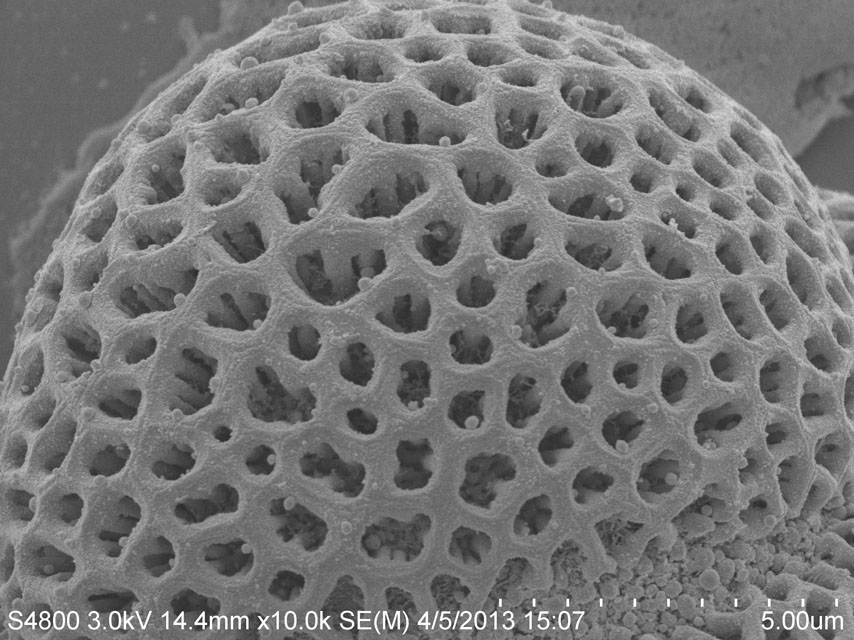

In [55]:
im.show()

In [56]:
exifdata = im.getexif()

In [57]:
# iterating over all EXIF data fields
for tag_id in exifdata:
    # get the tag name, instead of human unreadable tag id
    tag = TAGS.get(tag_id, tag_id)
    data = exifdata.get(tag_id)
    # decode bytes 
    if isinstance(data, bytes):
        data = data.decode()
    print(f"{tag:25}: {data}")

ImageWidth               : 2560
ImageLength              : 1920
BitsPerSample            : 8
Compression              : 1
PhotometricInterpretation: 3
StripOffsets             : (8, 10248, 20488, 30728, 40968, 51208, 61448, 71688, 81928, 92168, 102408, 112648, 122888, 133128, 143368, 153608, 163848, 174088, 184328, 194568, 204808, 215048, 225288, 235528, 245768, 256008, 266248, 276488, 286728, 296968, 307208, 317448, 327688, 337928, 348168, 358408, 368648, 378888, 389128, 399368, 409608, 419848, 430088, 440328, 450568, 460808, 471048, 481288, 491528, 501768, 512008, 522248, 532488, 542728, 552968, 563208, 573448, 583688, 593928, 604168, 614408, 624648, 634888, 645128, 655368, 665608, 675848, 686088, 696328, 706568, 716808, 727048, 737288, 747528, 757768, 768008, 778248, 788488, 798728, 808968, 819208, 829448, 839688, 849928, 860168, 870408, 880648, 890888, 901128, 911368, 921608, 931848, 942088, 952328, 962568, 972808, 983048, 993288, 1003528, 1013768, 1024008, 1034248, 1044488, 105472

In [59]:
from PIL import Image
from PIL.TiffTags import TAGS


with Image.open('data/3dsem/diatom-01.TIF') as img:
    meta_dict = {}
    for key in img.tag:      # don't really need iterkeys in this context
        meta_dict[TAGS.get(key,'missing')] = img.tag[key]

# Now you can print your desired unit:

print(meta_dict["PixelWidth"])

KeyError: 'PixelWidth'

In [60]:
meta_dict

{'ImageWidth': (2560,),
 'ImageLength': (1920,),
 'BitsPerSample': (8,),
 'Compression': (1,),
 'ColorMap': (0,
  0,
  257,
  514,
  771,
  1028,
  1285,
  1542,
  1799,
  2056,
  2313,
  2570,
  2827,
  3084,
  3341,
  3598,
  3855,
  4112,
  4369,
  4626,
  4883,
  5140,
  5397,
  5654,
  5911,
  6168,
  6425,
  6682,
  6939,
  7196,
  7453,
  7710,
  7967,
  8224,
  8481,
  8738,
  8995,
  9252,
  9509,
  9766,
  10023,
  10280,
  10537,
  10794,
  11051,
  11308,
  11565,
  11822,
  12079,
  12336,
  12593,
  12850,
  13107,
  13364,
  13621,
  13878,
  14135,
  14392,
  14649,
  14906,
  15163,
  15420,
  15677,
  15934,
  16191,
  16448,
  16705,
  16962,
  17219,
  17476,
  17733,
  17990,
  18247,
  18504,
  18761,
  19018,
  19275,
  19532,
  19789,
  20046,
  20303,
  20560,
  20817,
  21074,
  21331,
  21588,
  21845,
  22102,
  22359,
  22616,
  22873,
  23130,
  23387,
  23644,
  23901,
  24158,
  24415,
  24672,
  24929,
  25186,
  25443,
  25700,
  25957,
  26214,
  2647